In [80]:
import numpy as np 
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from thermal.derived_fields import (calc_length,
                                    calc_volume,
                                    Variable_at_ELA)

plt.rcParams['text.usetex'] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{siunitx}"
def write_roman(num):
    #https://stackoverflow.com/a/28777781
    from collections import OrderedDict
    
    roman = OrderedDict()
    roman[10] = "x"
    roman[9] = "ix"
    roman[5] = "v"
    roman[4] = "iv"
    roman[1] = "i"

    def roman_num(num):
        for r in roman.keys():
            x, y = divmod(num, r)
            yield roman[r] * x
            num -= (r * x)
            if num <= 0:
                break

    return "".join([a for a in roman_num(num)])


In [2]:
zarr_path = '../result/crmpt12/PeriodicSurges_Timeseries_9ka.zarr'

# open the full timeseries and load into memory
src = xr.open_zarr(zarr_path).compute()
# compute the annual rolling mean
src = src.rolling(t=10, min_periods=1).mean('t')
# interpolated time 
t_interp = np.linspace(0.0, 9e3, 900_00, endpoint=False)
# downsample to annual timesteps 
src = src.interp(t=t_interp,
                 method="linear",
                 kwargs={"fill_value": "extrapolate"})
# flip the beta values so they are decending
src = src.sortby('beta', ascending=False)

In [3]:
y = np.arange(0.1, 2.0, 0.1)[None,:]
x = np.arange(0, 9e3, 30)[:, None]
surge_timesteps = (x + y).flatten()

test = src.isel(SP=1).sel(t=surge_timesteps, method='nearest')

In [4]:
grouped = test.groupby_bins('t', bins=surge_timesteps[::19])
cum_flux = grouped.map(lambda x: x.flux_across_ELA.sum('t'))

dhdt = ((grouped.last().h_ELA - grouped.first().h_ELA) /2)

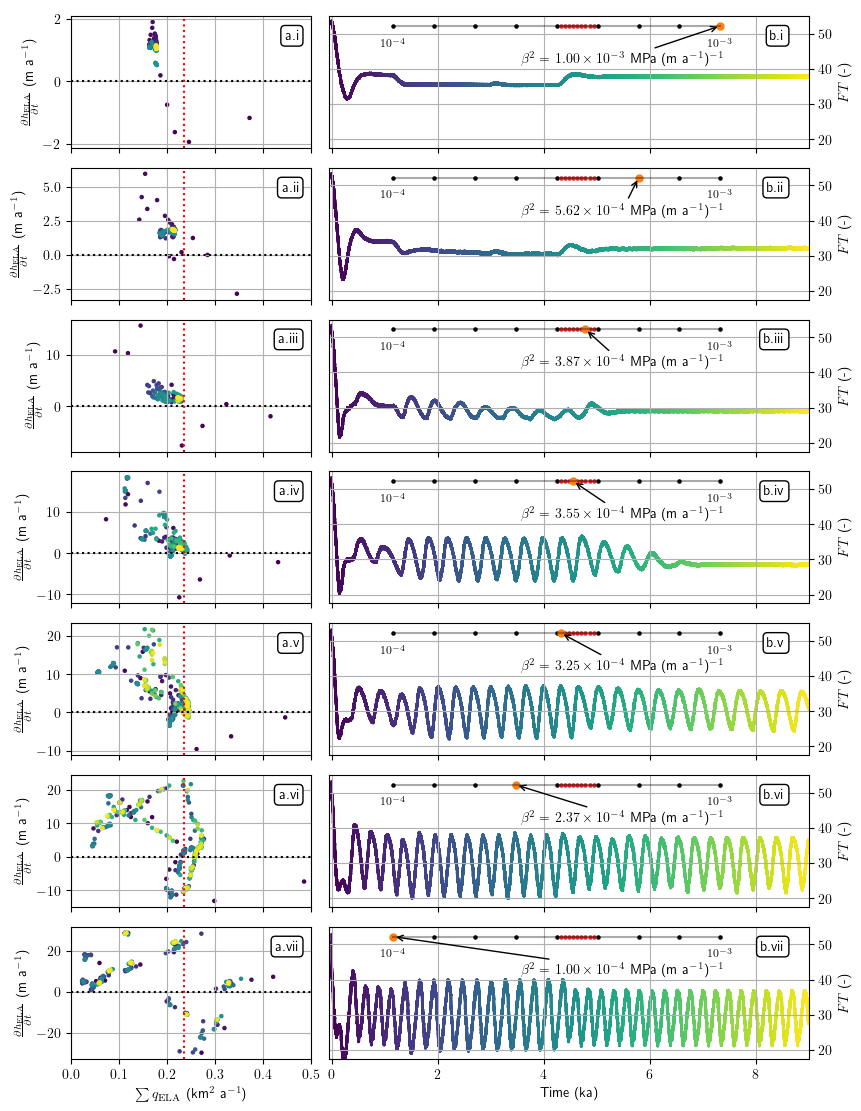

In [93]:
fig, ax = plt.subplots(7,2, sharex='col', #sharey='col', 
                       constrained_layout=True, width_ratios=[1,2], 
                       figsize=(8.5,11))

bins = surge_timesteps[::19]
bin_centers = surge_timesteps[::19] + (surge_timesteps[18::19] - surge_timesteps[::19])/2

norm =  plt.Normalize(0,9)

for i,beta in enumerate(src.beta[[0,2,6, 9, 12, 14, 17]]): 
    
    sub = src.sel(SP=30, beta=beta)
    sub_surging = sub.sel(t=surge_timesteps, method='nearest')
        
    grouped  = sub_surging.groupby_bins('t', bins=bins, right=False)
    cum_flux = grouped.map(lambda x: x.flux_across_ELA.sum('t')) / 1e6
    
    dhdt = ((grouped.last().h_ELA - grouped.first().h_ELA) / 2 )

    ax[i,0].scatter(cum_flux, dhdt, c=bins[:-1], s=5.0)
    
    ax[i,0].axhline(0.0,    ls=':', c='k')    
    ax[i,0].axvline(0.235, ls=':', c='r')
    ax[i,0].grid()
    ax[i,0].set_ylabel(r'$\frac{\partial h_{\rm ELA}}{\partial t}$ (m a$^{-1}$)')

    
    # ax[i,1].plot(sub.t, sub.percent_temperate, lw=1.0, c='k')
    ax[i,1].scatter(sub.t/1e3, sub.percent_temperate, 
                    c=sub.t/1e3, norm=norm, s=1.0, rasterized=True)
    ax[i,1].grid()

    ax[i,1].yaxis.tick_right()
    ax[i,1].yaxis.set_label_position("right")
    ax[i,1].set_ylabel(r'$FT$ (-)')
    ax[i,1].set_ylim(17.5,55)

    # ax[i,1].text(4.5, 47.5, 
    #              r'$\beta^2 = $' + f'{beta:1.3e}' + r' (MPa (m a$^{-1}$)$^{-1}$)',
    #              ha='center', va='center')
    
    ax[i,0].text(0.95, 0.85, 'a.' + write_roman(i+1),
                 ha='right', va='center', 
                 transform=ax[i,0].transAxes, 
                 bbox=dict(boxstyle="round", fc='w'))
    
    ax[i,1].text(0.95, 0.85, 'b.' + write_roman(i+1),
             ha='right', va='center', 
             transform=ax[i,1].transAxes, 
             bbox=dict(boxstyle="round", fc='w'))
    
    ax_inset = ax[i,1].inset_axes([0.1, 0.8, 0.75, 0.25])
    # make axis transparent 
    ax_inset.patch.set_alpha(0.0)
    
    # ax_inset = inset_axes(ax[i,1], loc="lower center", width="75%", height="5%", 
    #                       bbox_to_anchor=(0.5, 0.4, 0.7, 0.2))
                          # width="75%", height="5%", loc="lower center")
    ax_inset.plot(src.beta, np.ones(18), color='k', alpha=1/3)

    ax_inset.scatter(np.logspace(-4,-3,9), np.ones(9),color='k', s=5.0)
    ax_inset.scatter(np.geomspace(0.0004217,0.00031623, 11)[1:-1], 
                     np.ones(9), color='tab:red', s=5.0)

    
    ax_inset.scatter(beta, 1, color='tab:orange', s=25.0)
    
    # make the arrow and annotation of the current beta^2 value 
    ax_inset.annotate(r'$\beta^2 =$ \SI{' + f'{beta:1.2e}' + '}{} MPa (m a$^{-1}$)$^{-1}$', xy=(beta, 1), 
                      xytext=(0.4,-0.5), textcoords="axes fraction", 
                      va="center", ha="left", fontsize='medium',
                      arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
                   
        
    ax_inset.set_xscale('log') 
    
    ax_inset.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax_inset.set(yticklabels=[])  # remove the tick labels
    ax_inset.tick_params(axis='both',which='both', bottom=False, left=False)# remove the ticks
    
    ax_inset.tick_params(axis='both', labelsize=8)
        
    # Create offset transform by 5 points in x direction
    dx = 0/72.; dy = 10/72. 
    offset = plt.matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

    # apply offset transform to all x ticklabels.
    for label in ax_inset.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform()+offset)
        
ax[i,0].set_xlabel(r'$\sum q_{\rm ELA}$ (km$^2$ a$^{-1}$)')
ax[i,1].set_xlabel(r'Time (ka)')

ax[i,0].set_xlim(0,0.5)
ax[i,1].set_xlim(-0.05,9)

fig.savefig('../figs/crmpt12/Cummlative_flux_threshold.pdf', dpi=400)

In [ ]:
zarr_path = '../result/crmpt12/PeriodicSurges_Timeseries_9ka.zarr'

# open the full timeseries and load into memory
src = xr.open_zarr(zarr_path).compute()
# compute the annual rolling mean
src = src.rolling(t=10, min_periods=1).mean('t')
# downsample to annual timesteps 
src = src.interp(t=np.linspace(0.0, 9e3, 900_00, endpoint=False),
                 method="linear",
                 kwargs={"fill_value": "extrapolate"})
# flip the beta values so they are decending
src = src.sortby('beta', ascending=False)

In [ ]:
y = np.arange(0.1, 2.0, 0.1)[None,:]
x = np.arange(0, 9e3, 30)[:, None]
surge_timesteps = (x + y).flatten()

test = src.isel(SP=1).sel(t=surge_timesteps, method='nearest')

In [ ]:
fig = plt.figure(layout="constrained")

gs = gridspec.GridSpec(4, 2, figure=fig)

ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2:4, 0])
ax3 = fig.add_subplot(gs[0, 1])


ax4 = fig.add_subplot(gs[1, 1], sharex=ax3)
ax5 = fig.add_subplot(gs[2, 1], sharex=ax3)
ax6 = fig.add_subplot(gs[3, 1], sharex=ax3)
ax7 = ax4.twinx()
ax8 = ax6.twinx()


cols = [[ax1,ax2], [ax3, ax5], [ax4, ax6], [ax7, ax8]]


bins = surge_timesteps[::19]
bin_centers = surge_timesteps[::19] + (surge_timesteps[18::19] - surge_timesteps[::19])/2


for i,beta in enumerate(src.beta[[0,-1]]): 


    test = src.sel(SP=30, beta=beta).sel(t=surge_timesteps, method='nearest')
        
    grouped  = test.groupby_bins('t', bins=bins, right=False)
    cum_flux = grouped.map(lambda x: x.flux_across_ELA.sum('t')) / 1e6
    
    dhdt = ((grouped.last().h_ELA - grouped.first().h_ELA) / 2 )

    cols[0][i].scatter(cum_flux, dhdt, c=bins[:-1], s=5.0)
    
    cols[0][i].axhline(0.0,    ls=':', c='k')    
    cols[0][i].axvline(0.235, ls=':', c='r')
    cols[0][i].grid()
    cols[0][i].set_ylabel(r'$\frac{\partial h_{\rm ELA}}{\partial t}$ (m a$^{-1}$)')
    cols[0][i].set_xlim(0,0.5)
    # cols[0][i].set_ylim(-30,30)
    
    
    cols[1][i].plot(src.t,  src.sel(SP=30, beta=beta).percent_temperate)
    cols[2][i].plot(bin_centers[:-1], dhdt, marker='x', lw=1.0)
    cols[2][i].axhline(0.0, ls=':', c='k')

    
    cols[3][i].plot(src.t,  src.sel(SP=30, beta=beta).flux_across_ELA/1e4)
    
    cols[3][i].set_ylim(0, 3.5)
    
    
cols[2][i].set_xlim(7e3, 8e3)

for i in range(3): 
    cols[i][0].tick_params(labelbottom=False)
    
    if i == 1: 
        cols[i][1].tick_params(labelbottom=False,)